# Parcels as an ODE solver
`Parcels` is, at its heart, an interpolation and integration machine! While it's designed for simulating the trajectories of particles (parcels!) in geophysical applications, it can easily be used for non-geophysical problem solving. In this notebook, we consider two examples of numerically solving systems of ODE's: the Lorenz "butterfly" attractor, and the Lotka-Volterra predator-prey model.

## Lorenz Attractor
In the first part of this notebook, we demonstrate how to simulate and visualize the Lorenz attractor using `parcels`. We will implement three numerical integration schemes (EE, RK2, and RK4), and visualise and compare the results.

### The Lorenz System: Equations and Background

The Lorenz system is a set of three coupled, nonlinear ordinary differential equations originally developed to model atmospheric convection. It is famous for exhibiting chaotic behavior and is a classic example in the study of dynamical systems and chaos theory.

The equations are:
$$
\begin{align*}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x (\rho - z) - y, \\
\frac{dz}{dt} &= x y - \beta z,
\end{align*}
$$

where $x, y, z$ are the system state variables (can be interpreted as convective intensity, temperature difference, and vertical temperature profile, respectively), $\sigma$ is the Prandtl number, $\rho$ is the Rayleigh number, and $\beta$ is a geometric factor. For certain parameter values (e.g., $\sigma=10$, $\rho=28$, $\beta=8/3$), the system exhibits sensitive dependence on initial conditions, leading to the famous "butterfly effect."


Since we will model the system with three different schemes, namely the Explicit Euler, the Runge-Kutta order 2, and Runge-Kutta order 4 schemes, we will also keep track of the "energy" of the state over time. The "Lorenz energy" $E$ can be computed as:

$$
\begin{align*}
E = \frac{x^2}{2} + y^2 + z^2 - z.
\end{align*}
$$

When comparing different integration schemes, or timesteps, the simulation that best "conserves" this "Lorenz energy" would (typically) be considered more accurate.

### Modelling the Lorenz system with an EE scheme

In [1]:
## Import required libraries for the Lorenz attractor simulation
import numpy as np
import xarray as xr
import parcels
import matplotlib.pyplot as plt
from datetime import timedelta

# For some cells we plot an interactive 3D plot, however you will need plotly installed
#import plotly.graph_objects as go

In [2]:
# Create a dummy fieldset (no background flow) for the Lorenz system
fieldset = parcels.FieldSet.from_data(
    {"U": 0, "V": 0}, {"lon": 0, "lat": 0}, mesh="flat"
)

In [3]:
# Add constants for the Lorenz system to the fieldset
fieldset.add_constant('rho', 28.)     # Rayleigh number
fieldset.add_constant('sigma', 10.)   # Prandtl number
fieldset.add_constant('beta', 8./3.)  # Geometric factor

In [4]:
# Define initial positions for two Lorenz particles
initial_position = [[0,0],       # x-coordinates
                    [1,1],       # y-coordinates
                    [1.05, 2.5]] # z-coordinates (slightly different to show sensitivity to initial conditions)

In [5]:
# Set simulation parameters for the Lorenz system
runtime = timedelta(milliseconds=50000)  # Total simulation time
dt = timedelta(milliseconds=10)          # Time step for integration
outputdt = dt                            # Output interval
chunks = int(runtime/outputdt)           # Chunk size (important for fast IO)

In [6]:
# Define a custom particle class for Lorenz with an energy variable
LorenzParticle = parcels.JITParticle
LorenzParticle = LorenzParticle.add_variable("energy", np.float64)

#setattr(LorenzParticle, "energy", parcels.Variable("energy", np.float64))

In [7]:
# Create a ParticleSet for the Lorenz system
pset = parcels.ParticleSet(fieldset=fieldset, pclass=LorenzParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]],
    depth=[initial_position[2]])

In [8]:
# Construct an output file for storing simulation results
pfile = pset.ParticleFile(name="output/lorenz.zarr", outputdt=outputdt, chunks=(len(pset), chunks))  # Important to chunk the output for fast IO

In [9]:
# Define the Lorenz kernel using the Explicit Euler scheme
def LorenzKernelEE(particle, fieldset, time):
    """Lorenz attractor kernel (Explicit Euler)"""
    x = particle.lon
    y = particle.lat
    z = particle.depth
    # Euler integration for Lorenz equations
    particle_dlon += fieldset.sigma * (y - x) * particle.dt      # dx/dt
    particle_dlat += (x * (fieldset.rho - z) - y) * particle.dt  # dy/dt
    particle_ddepth += (x * y - fieldset.beta * z) * particle.dt # dz/dt

In [ ]:
# Kernel to compute the "energy" of a Lorenz simulation at each step
def LorenzEnergy(particle, fieldset, time):
    x = particle.lon
    y = particle.lat
    z = particle.depth
    # Compute and set the Lorenz energy variable
    particle.energy = (x**2)/ 2. + y**2  + z**2 - z

In [11]:
# Run the simulation using the Explicit Euler kernel and energy calculation
pset.execute([LorenzKernelEE, LorenzEnergy],
             runtime=runtime,
             dt=dt,
             output_file=pfile)

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning: x declared in multiple Kernels
  kernel_ccode = kernelgen.generate(deepcopy(self.py_ast), self.funcvars)
/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning: y declared in multiple Kernels
  kernel_ccode = kernelgen.generate(deepcopy(self.py_ast), self.funcvars)
/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning: z declared in multiple Kernels
  kernel_ccode = kernelgen.generate(deepcopy(self.py_ast), self.funcvars)


INFO: Output files are stored in output/lorenz.zarr.
100%|██████████| 50.0/50.0 [00:31<00:00,  1.60it/s]               


In [12]:
# Load the simulation results from the output file
ds_ee = xr.open_zarr(pfile.fname, decode_timedelta=True)

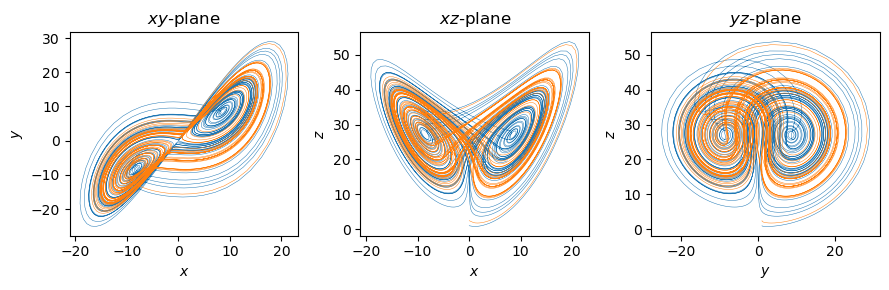

In [13]:
# Plot the Lorenz trajectories in 2D projections
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

# XY plane
ax[0].plot(ds_ee.lon.T, ds_ee.lat.T, lw=0.35)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_title(r'$xy$-plane')

# XZ plane
ax[1].plot(ds_ee.lon.T, ds_ee.z.T, lw=0.35)
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$z$')
ax[1].set_title(r'$xz$-plane')

# YZ plane
ax[2].plot(ds_ee.lat.T, ds_ee.z.T, lw=0.35)
ax[2].set_xlabel(r'$y$')
ax[2].set_ylabel(r'$z$')
ax[2].set_title(r'$yz$-plane')

plt.tight_layout()
plt.show()

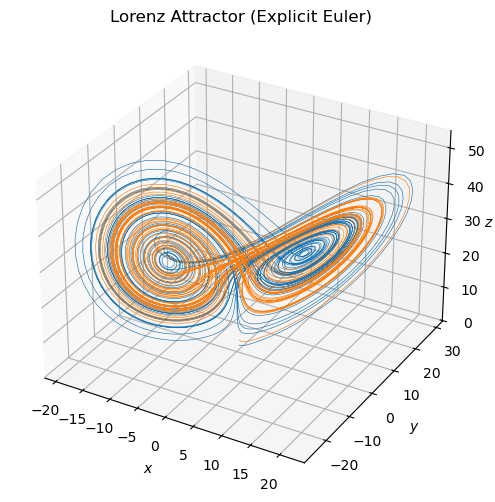

In [14]:
# Plot the Lorenz attractor in 3D using Matplotlib
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for particle_id in ds_ee.trajectory:
    ax.plot(ds_ee.lon.sel(trajectory=particle_id), ds_ee.lat.sel(trajectory=particle_id), ds_ee.z.sel(trajectory=particle_id), lw=0.45)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$', labelpad=-2)
ax.set_title('Lorenz Attractor (Explicit Euler)')
plt.show()

In [15]:
# Interactive 3D plot of the two trajectories
# You will need plotly installed, you can do this with "conda install -c conda-forge plotly" once you have activated your parcels environment
import plotly.graph_objects as go

fig = go.Figure()
for particle_id in ds_ee.trajectory:
    fig.add_trace(go.Scatter3d(
        x=ds_ee.lon.sel(trajectory=particle_id),
        y=ds_ee.lat.sel(trajectory=particle_id),
        z=ds_ee.z.sel(trajectory=particle_id),
        mode='lines',
        line=dict(width=1)
    ))
fig.update_layout(scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))
fig.show()

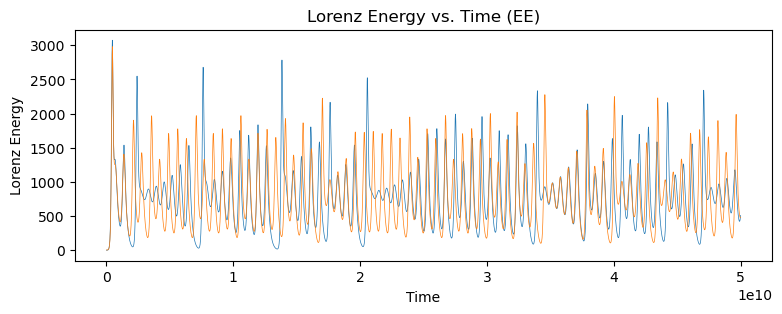

In [16]:
# Plot the computed "Lorenz energy" of each solution over time
fig = plt.figure(figsize=(9,3))
plt.plot(ds_ee.time.T, ds_ee.energy.T, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Lorenz Energy")
plt.title('Lorenz Energy vs. Time (EE)')
plt.show()

### Using an RK2 integration scheme
We will now create a kernel that uses the RK2 scheme, and compare it to the EE scheme.

In [17]:
# Re-create the ParticleSet for the RK2
pset = parcels.ParticleSet(fieldset=fieldset, pclass=LorenzParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]],
    depth=[initial_position[2]])

In [18]:
# Define the Lorenz kernel using the RK2 (second-order Runge-Kutta) scheme
def LorenzKernelRK2(particle, fieldset, time):
    """Lorenz attractor kernel (RK2)"""
    x = particle.lon
    y = particle.lat
    z = particle.depth
    dt = particle.dt
    # k1: Euler step
    dx1 = fieldset.sigma * (y - x) * dt
    dy1 = (x * (fieldset.rho - z) - y) * dt
    dz1 = (x * y - fieldset.beta * z) * dt
    # k2: Evaluate at Euler step
    x2 = x + dx1
    y2 = y + dy1
    z2 = z + dz1
    dx2 = fieldset.sigma * (y2 - x2) * dt
    dy2 = (x2 * (fieldset.rho - z2) - y2) * dt
    dz2 = (x2 * y2 - fieldset.beta * z2) * dt
    # RK2 update (average of k1 and k2)
    particle_dlon += 0.5 * (dx1 + dx2)
    particle_dlat += 0.5 * (dy1 + dy2)
    particle_ddepth += 0.5 * (dz1 + dz2)

In [19]:
# Construct an output file for the RK2 simulation
pfile = pset.ParticleFile(name="output/lorenzRK2.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

In [20]:
# Run the simulation using the RK2 kernel and energy calculation
pset.execute([LorenzKernelRK2, LorenzEnergy],
             runtime=runtime,
             dt=dt,
             output_file=pfile)

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

x declared in multiple Kernels

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

y declared in multiple Kernels

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

z declared in multiple Kernels



INFO: Output files are stored in output/lorenzRK2.zarr.
100%|██████████| 50.0/50.0 [00:56<00:00,  1.13s/it]               


In [21]:
# Load the RK2 simulation results from the output file
ds_rk2 = xr.open_zarr(pfile.fname, decode_timedelta=True)

In [22]:
# Interactive 3D plot of the Lorenz trajectories (RK2) using Plotly
fig = go.Figure()
for particle_id in ds_rk2.trajectory:
    fig.add_trace(go.Scatter3d(
        x=ds_rk2.lon.sel(trajectory=particle_id),
        y=ds_rk2.lat.sel(trajectory=particle_id),
        z=ds_rk2.z.sel(trajectory=particle_id),
        mode='lines',
        line=dict(width=1)
    ))
fig.update_layout(scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
                  width=500,
                  margin=dict(r=20, b=10, l=10, t=10))
fig.show()

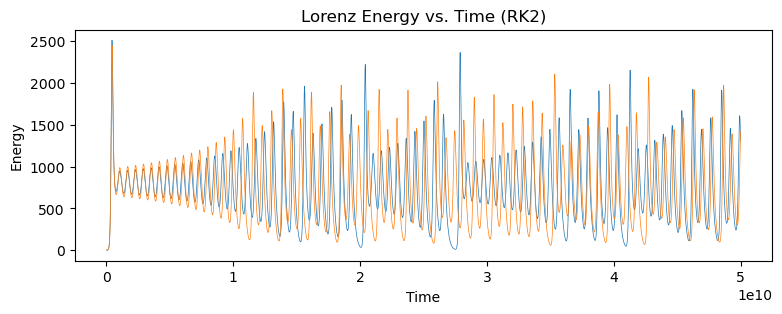

In [23]:
# Plot the computed "Lorenz energy" of the simulations (RK2) over time
fig = plt.figure(figsize=(9,3))
plt.plot(ds_rk2.time.T, ds_rk2.energy.T, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title('Lorenz Energy vs. Time (RK2)')
plt.show()

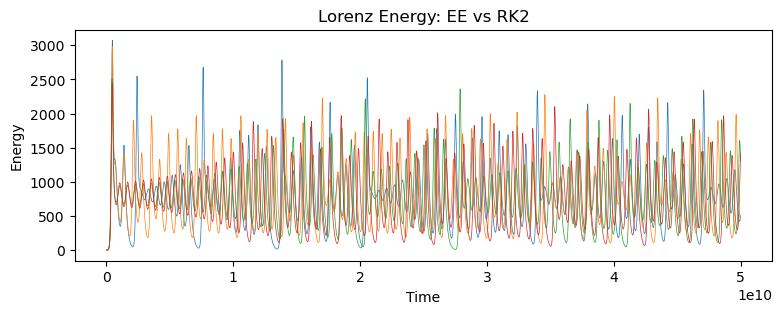

In [24]:
# Compare the energy evolution for EE and RK2 schemes
fig = plt.figure(figsize=(9, 3))
plt.plot(ds_ee.time.T, ds_ee.energy.T, lw=0.5, label='EE')
plt.plot(ds_rk2.time.T, ds_rk2.energy.T, lw=0.5, label='RK2')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title('Lorenz Energy: EE vs RK2')
plt.show()

In [25]:
# 3D plot of the difference between EE and RK2 trajectories
fig = go.Figure()
for particle_id in range(len(ds_ee.trajectory)):
    ee_particle_id = ds_ee.trajectory[particle_id]
    rk2_particle_id = ds_rk2.trajectory[particle_id]
    fig.add_trace(go.Scatter3d(
        x=ds_ee.lon.sel(trajectory=ee_particle_id) - ds_rk2.lon.sel(trajectory=rk2_particle_id),
        y=ds_ee.lat.sel(trajectory=ee_particle_id) - ds_rk2.lat.sel(trajectory=rk2_particle_id),
        z=ds_ee.z.sel(trajectory=ee_particle_id) - ds_rk2.z.sel(trajectory=rk2_particle_id),
        mode='lines',
        line=dict(width=1)
    ))
fig.update_layout(scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10),
                  title='Difference: EE - RK2')
fig.show()

#### Now let's create an RK4 scheme

In [26]:
# Create a kernel for the Lorenz attractor using an RK4 scheme
def LorenzKernelRK4(particle, fieldset, time):
    """Lorenz attractor kernel (RK4)"""
    x = particle.lon
    y = particle.lat
    z = particle.depth
    dt = particle.dt
    # k1
    dx1 = fieldset.sigma * (y - x) * dt
    dy1 = (x * (fieldset.rho - z) - y) * dt
    dz1 = (x * y - fieldset.beta * z) * dt
    # k2
    x2 = x + 0.5 * dx1
    y2 = y + 0.5 * dy1
    z2 = z + 0.5 * dz1
    dx2 = fieldset.sigma * (y2 - x2) * dt
    dy2 = (x2 * (fieldset.rho - z2) - y2) * dt
    dz2 = (x2 * y2 - fieldset.beta * z2) * dt
    # k3
    x3 = x + 0.5 * dx2
    y3 = y + 0.5 * dy2
    z3 = z + 0.5 * dz2
    dx3 = fieldset.sigma * (y3 - x3) * dt
    dy3 = (x3 * (fieldset.rho - z3) - y3) * dt
    dz3 = (x3 * y3 - fieldset.beta * z3) * dt
    # k4
    x4 = x + dx3
    y4 = y + dy3
    z4 = z + dz3
    dx4 = fieldset.sigma * (y4 - x4) * dt
    dy4 = (x4 * (fieldset.rho - z4) - y4) * dt
    dz4 = (x4 * y4 - fieldset.beta * z4) * dt
    # RK4 update
    particle_dlon += (dx1 + 2*dx2 + 2*dx3 + dx4) / 6
    particle_dlat += (dy1 + 2*dy2 + 2*dy3 + dy4) / 6
    particle_ddepth += (dz1 + 2*dz2 + 2*dz3 + dz4) / 6

In [28]:
# Recreate the particle set for the RK4 simulation
pset = parcels.ParticleSet(fieldset=fieldset, pclass=LorenzParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]],
    depth=[initial_position[2]])

# Construct an output file for the RK4 simulation
pfile = pset.ParticleFile(name="output/lorenzRK4.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

# Run the simulation
pset.execute([LorenzKernelRK4, LorenzEnergy],
             runtime=runtime,
             dt=dt,
             output_file=pfile)

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

x declared in multiple Kernels

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

y declared in multiple Kernels

/Users/denes001/anaconda3/envs/parcels_workshop/lib/python3.13/site-packages/parcels/kernel.py:254: KernelWarning:

z declared in multiple Kernels



INFO: Output files are stored in output/lorenzRK4.zarr.
100%|██████████| 50.0/50.0 [00:30<00:00,  1.61it/s]               


In [29]:
# Load in the RK4 results
ds_rk4 = xr.open_zarr('output/lorenzRK4.zarr', decode_timedelta=True)

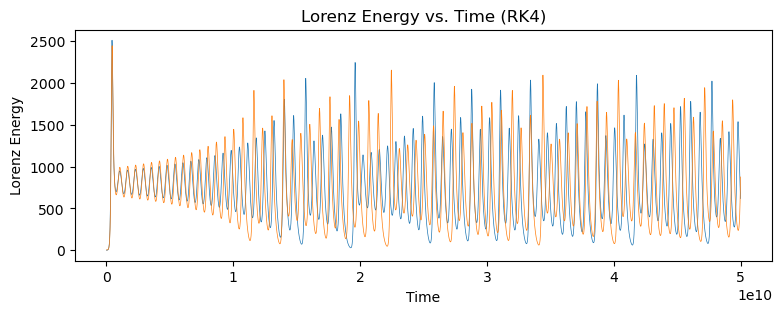

In [30]:
# Plot the "Lorenz Energy" for the RK4 simulation over time
fig = plt.figure(figsize=(9, 3))
plt.plot(ds_rk4.time.T, ds_rk4.energy.T, lw=0.5)
plt.xlabel("Time")
plt.ylabel("Lorenz Energy")
plt.title('Lorenz Energy vs. Time (RK4)')
plt.show()

In [31]:
# Compare the difference in solutions to the RK2 simulation
fig = go.Figure()
for particle_id in range(len(ds_rk4.trajectory)):
    rk4_particle_id = ds_rk4.trajectory[particle_id]
    rk2_particle_id = ds_rk2.trajectory[particle_id]
    fig.add_trace(go.Scatter3d(
        x=ds_rk4.lon.sel(trajectory=rk4_particle_id) - ds_rk2.lon.sel(trajectory=rk2_particle_id),
        y=ds_rk4.lat.sel(trajectory=rk4_particle_id) - ds_rk2.lat.sel(trajectory=rk2_particle_id),
        z=ds_rk4.z.sel(trajectory=rk4_particle_id) - ds_rk2.z.sel(trajectory=rk2_particle_id),
        mode='lines',
        line=dict(width=1)
    ))
fig.update_layout(scene = dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))
fig.show()

Mean Energy (EE): [778.6749809 784.195365 ]
Mean Energy (RK2): [743.15242127 729.6471457 ]
Mean Energy (RK4): [740.56542082 729.13705466]


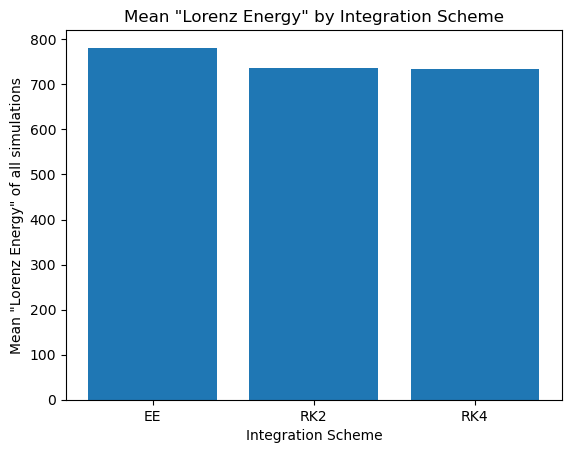

In [32]:
# Compute and print the mean energy for each scheme
print("Mean Energy (EE):", ds_ee.energy.mean(dim='obs').values)
print("Mean Energy (RK2):", ds_rk2.energy.mean(dim='obs').values)
print("Mean Energy (RK4):", ds_rk4.energy.mean(dim='obs').values)
plt.bar(['EE', 'RK2', 'RK4'], [ds_ee.energy.mean().values, ds_rk2.energy.mean().values, ds_rk4.energy.mean().values])
plt.ylabel('Mean "Lorenz Energy" of all simulations')
plt.xlabel('Integration Scheme')
plt.title('Mean "Lorenz Energy" by Integration Scheme')
plt.show()

#### Additional exercises:
1. Explore what happens when you change the timestep of each scheme. Can you sufficiently shorten the timestep of the EE simulation so that it gives similar results to the RK4 simulation?

## Lotka-Volterra Predator-Prey System

In the second part of this notebook, we demonstrate how to simulate and visualize the Lotka-Volterra equations using `parcels`. Here, we will implement two numerical integration schemes (EE, andRK2), and visualise and compare the results.


### The Lotka-Volterra equations
The Lotka-Volterra equations describe a classic model of predator-prey dynamics. The Lotka-Volterra equations are:

$$
\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta x y, \\
\frac{dy}{dt} &= -\gamma y + \delta x y,
\end{align*}
$$

where $x$ is the prey population, $y$ is the predator population, and the parameters of the model are: $\alpha$ the prey growth rate, $\beta$ the predation rate,  $\gamma$ the predator death rate, and $\delta$ the predator reproduction rate per prey eaten.


In [33]:
# Set Lotka-Volterra model parameters for the simulation
fieldset.add_constant('alpha', 2./3.)   # Prey (e.g., rabbits) growth rate
fieldset.add_constant('beta', 4./3.)    # Predation rate coefficient # This will overwrite the beta we added before!
fieldset.add_constant('gamma', 1.)      # Predator (e.g., foxes) death rate
fieldset.add_constant('delta', 1.)      # Predator reproduction rate per prey eaten

In [34]:
# Define the Lotka-Volterra kernel using the explicit Euler method
def LotkaVolteraKernelEE(particle, fieldset, time):
    x = particle.lon  # Pretend lons are our prey population
    y = particle.lat  # Pretend lats are our predator population
    # Euler update for prey and predator
    particle_dlon += (fieldset.alpha * x - fieldset.beta * x * y) * particle.dt
    particle_dlat += (-fieldset.gamma * y + fieldset.delta * x * y) * particle.dt

In [35]:
# Define the Lotka-Volterra kernel using the RK2 (second-order Runge-Kutta) scheme
def LotkaVolteraKernelRK2(particle, fieldset, time):
    x = particle.lon  # Pretend lons are our prey population
    y = particle.lat  # Pretend lats are our predator population
    # k1
    dx1 = (fieldset.alpha * x - fieldset.beta * x * y) * particle.dt
    dy1 = (-fieldset.gamma * y + fieldset.delta * x * y) * particle.dt
    # k2 (Euler step)
    x2 = x + dx1
    y2 = y + dy1
    dx2 = (fieldset.alpha * x2 - fieldset.beta * x2 * y2) * particle.dt
    dy2 = (-fieldset.gamma * y2 + fieldset.delta * x2 * y2) * particle.dt
    # RK2 update
    particle_dlon += 0.5 * (dx1 + dx2)
    particle_dlat += 0.5 * (dy1 + dy2)

In [36]:
# Define the Lotka-Volterra kernel using the RK4 (fourth-order Runge-Kutta) scheme
def LotkaVolteraKernelRK4(particle, fieldset, time):
    x = particle.lon  # Pretend lons are our prey population
    y = particle.lat  # Pretend lats are our predator population
    dt = particle.dt
    # k1
    dx1 = (fieldset.alpha * x - fieldset.beta * x * y) * dt
    dy1 = (-fieldset.gamma * y + fieldset.delta * x * y) * dt
    # k2
    x2 = x + 0.5 * dx1
    y2 = y + 0.5 * dy1
    dx2 = (fieldset.alpha * x2 - fieldset.beta * x2 * y2) * dt
    dy2 = (-fieldset.gamma * y2 + fieldset.delta * x2 * y2) * dt
    # k3
    x3 = x + 0.5 * dx2
    y3 = y + 0.5 * dy2
    dx3 = (fieldset.alpha * x3 - fieldset.beta * x3 * y3) * dt
    dy3 = (-fieldset.gamma * y3 + fieldset.delta * x3 * y3) * dt
    # k4
    x4 = x + dx3
    y4 = y + dy3
    dx4 = (fieldset.alpha * x4 - fieldset.beta * x4 * y4) * dt
    dy4 = (-fieldset.gamma * y4 + fieldset.delta * x4 * y4) * dt
    # RK4 update (weighted average)
    particle_dlon += (dx1 + 2*dx2 + 2*dx3 + dx4) / 6.0
    particle_dlat += (dy1 + 2*dy2 + 2*dy3 + dy4) / 6.0

In [37]:
# Simulation settings
runtime = timedelta(milliseconds=50000)
dt = timedelta(milliseconds=10)
outputdt = dt
chunks = int(runtime/outputdt) # Because we will store a lot of positions, to speed up our simulation we need to chunk the output datafile

initial_position = [np.linspace(0.4,1.8,10, endpoint=True),       # initial x (prey)
                    np.linspace(0.4,1.8,10, endpoint=True)]       # initial y (predator)



In [38]:
# Run the simulation for EE scheme
pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.JITParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]])

pfile = pset.ParticleFile(name="output/lotkavolterraEE.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

pset.execute(LotkaVolteraKernelEE,
             runtime=runtime,
             dt=dt,
             output_file=pfile)

# Run the simulation for RK2 scheme
pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.JITParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]])

pfile = pset.ParticleFile(name="output/lotkavolterraRK2.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

pset.execute(LotkaVolteraKernelRK2,
             runtime=runtime,
             dt=dt,
             output_file=pfile)

# Run the simulation for RK4 scheme
pset = parcels.ParticleSet(fieldset=fieldset, pclass=parcels.JITParticle,
    lon=[initial_position[0]],
    lat=[initial_position[1]])

pfile = pset.ParticleFile(name="output/lotkavolterraRK4.zarr", outputdt=outputdt, chunks=(len(pset), chunks))

pset.execute(LotkaVolteraKernelRK4,
             runtime=runtime,
             dt=dt,
             output_file=pfile)

INFO: Output files are stored in output/lotkavolterraEE.zarr.
100%|██████████| 50.0/50.0 [00:25<00:00,  2.00it/s]               
INFO: Output files are stored in output/lotkavolterraRK2.zarr.
100%|██████████| 50.0/50.0 [00:25<00:00,  1.98it/s]              
INFO: Output files are stored in output/lotkavolterraRK4.zarr.
100%|██████████| 50.0/50.0 [00:25<00:00,  1.96it/s]               


In [39]:
# Load the simulation results using the EE and RK2 schemes
ds_ee = xr.open_zarr("output/lotkavolterraEE.zarr", decode_timedelta=True)
ds_rk2 = xr.open_zarr("output/lotkavolterraRK2.zarr", decode_timedelta=True)
ds_rk4 = xr.open_zarr("output/lotkavolterraRK4.zarr", decode_timedelta=True)

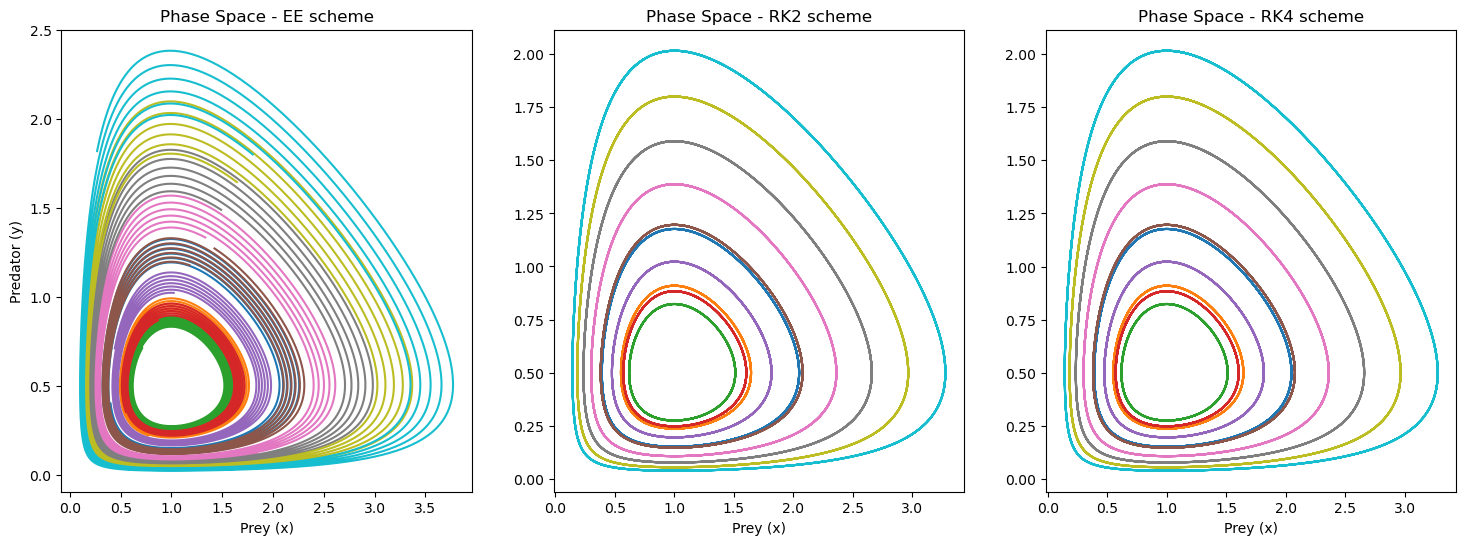

In [40]:
# Plot the phase space (prey vs. predator) trajectorys to show the cyclical nature of the populations
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].plot(ds_ee['lon'].T, ds_ee['lat'].T)
ax[0].set_xlabel('Prey (x)')
ax[0].set_ylabel('Predator (y)')
ax[0].set_title('Phase Space - EE scheme')

ax[1].plot(ds_rk2['lon'].T, ds_rk2['lat'].T)
ax[1].set_xlabel('Prey (x)')
ax[1].set_title('Phase Space - RK2 scheme')

ax[2].plot(ds_rk4['lon'].T, ds_rk4['lat'].T)
ax[2].set_xlabel('Prey (x)')
ax[2].set_title('Phase Space - RK4 scheme')

plt.show()

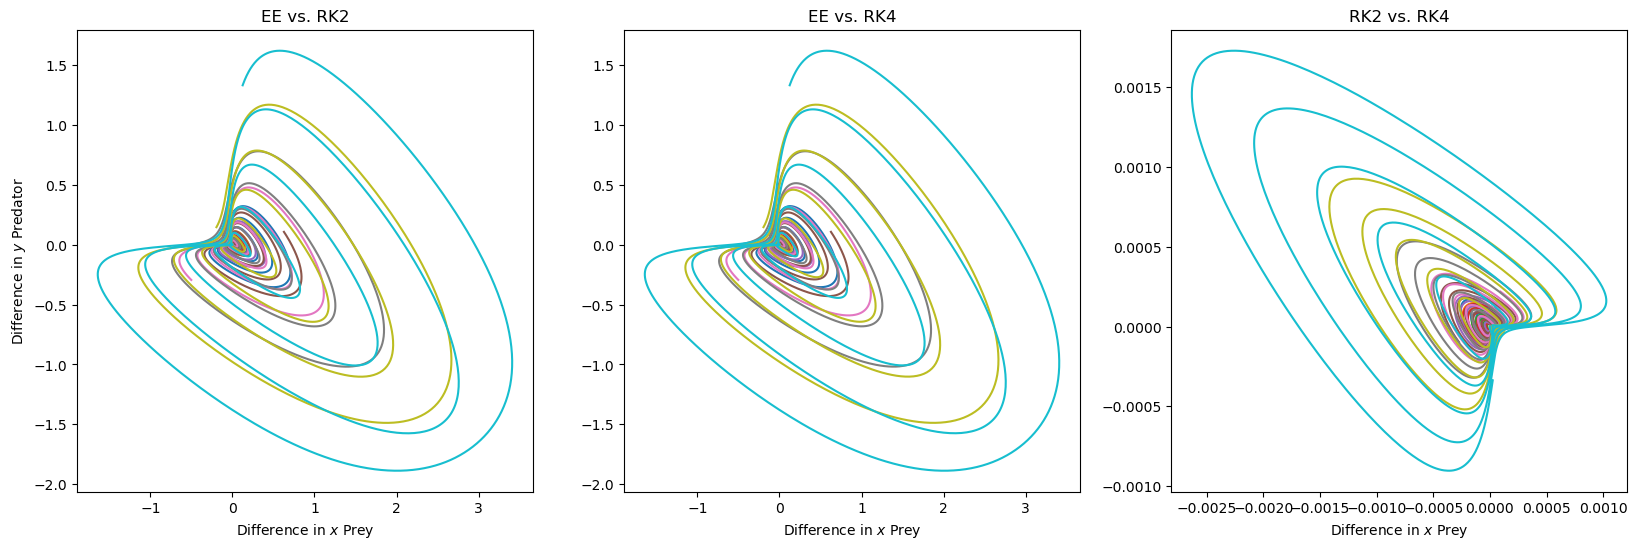

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax[0].plot(ds_ee['lon'].T.values - ds_rk2['lon'].T.values, ds_ee['lat'].T.values - ds_rk2['lat'].T.values)
ax[0].set_xlabel('Difference in $x$ Prey')
ax[0].set_ylabel('Difference in $y$ Predator')
ax[0].set_title('EE vs. RK2')

ax[1].plot(ds_ee['lon'].T.values - ds_rk4['lon'].T.values, ds_ee['lat'].T.values - ds_rk4['lat'].T.values)
ax[1].set_xlabel('Difference in $x$ Prey')
ax[1].set_title('EE vs. RK4')

ax[2].plot(ds_rk2['lon'].T.values - ds_rk4['lon'].T.values, ds_rk2['lat'].T.values - ds_rk4['lat'].T.values)
ax[2].set_xlabel('Difference in $x$ Prey')
ax[2].set_title('RK2 vs. RK4')

plt.show()

Note: the EE scheme is unstable, we expect to see periodic trajectories here! Does the RK4 scheme perform better than the RK2?

#### Additional exercises:
1. Can you achieve RK2/4 level accuracy with a shorter timestep for the EE scheme?